In [117]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('fivethirtyeight')

In [24]:
raw_data = pd.read_csv("Online_Retail.csv")
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/10 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/10 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/10 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/10 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/10 08:26,3.39,17850.0,United Kingdom


In [25]:
sales_data = raw_data.drop(['InvoiceNo','Description','CustomerID','Country','UnitPrice'], axis = 1)
sales_data['InvoiceDate'] = pd.to_datetime(sales_data['InvoiceDate'])
print(sales_data.info())
sales_data.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 3 columns):
StockCode      541909 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 12.4+ MB
None


RangeIndex(start=0, stop=541909, step=1)

In [148]:
def extract_product(product_id):
    #pull out all transactions of one product and drop StockCode
    product = sales_data.loc[sales_data['StockCode'] == product_id].drop('StockCode',axis=1)
    product=product.set_index(['InvoiceDate']) #Convert to timeseries 

    #DownSampling to a day
    day_summary = pd.DataFrame()
    day_summary['Quantity'] = product.Quantity.resample('D').sum()
    day_summary = day_summary.fillna(0) #replacing NaN with 0
    day_summary = day_summary.clip(0) #replace -ve values with 0

    day_summary = day_summary['2010-12-12':]#trim as almost no data available before this date
    day_summary['Quantity']+=1#ti avoid -inf while taking log transformation 
    print(day_summary.describe())
    #plot
    fig, ax1 = plt.subplots()
    ax1.plot(day_summary.index, day_summary['Quantity'])
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Quantity')
    # ax1.set_ylim(0,100)
    plt.show()
    return day_summary

         Quantity
count  364.000000
mean    38.774725
std     75.402054
min      1.000000
25%      1.000000
50%     15.000000
75%     37.000000
max    658.000000


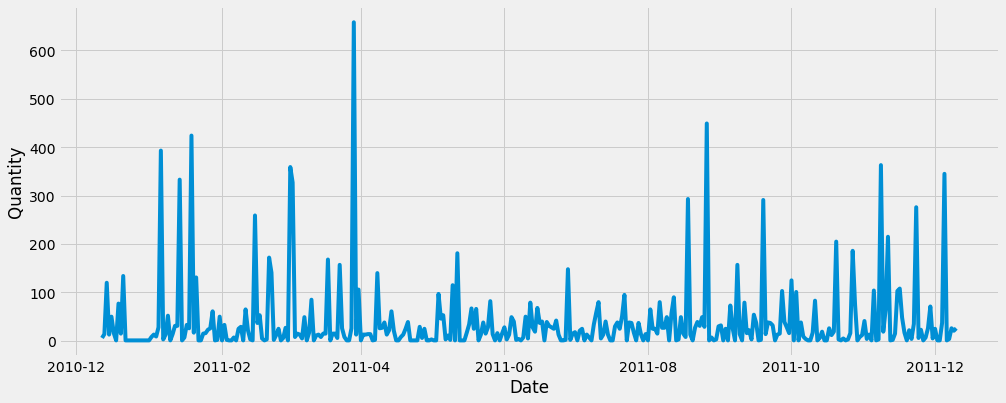

,Quantity
InvoiceDate,
2010-12-12,6.0
2010-12-13,14.0
2010-12-14,120.0
2010-12-15,13.0
2010-12-16,50.0


In [149]:
day_summary = extract_product('22629')
day_summary.head()

In [150]:
#required by prophet
day_summary.reset_index(inplace=True)
day_summary = day_summary.rename(columns={'Quantity': 'y','InvoiceDate': 'ds'})
day_summary.head()

,ds,y
0,2010-12-12,6.0
1,2010-12-13,14.0
2,2010-12-14,120.0
3,2010-12-15,13.0
4,2010-12-16,50.0


In [151]:
train,test = day_summary[:-10],day_summary[-10:]

In [152]:
train.head()

,ds,y
0,2010-12-12,6.0
1,2010-12-13,14.0
2,2010-12-14,120.0
3,2010-12-15,13.0
4,2010-12-16,50.0


In [153]:
test.head()

,ds,y
354,2011-12-01,25.0
355,2011-12-02,1.0
356,2011-12-03,1.0
357,2011-12-04,37.0
358,2011-12-05,345.0


In [170]:
my_model = Prophet(daily_seasonality=True)

In [171]:
my_model.fit(train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [172]:
future_dates = my_model.make_future_dataframe(periods=10,freq='D')
future_dates.tail()

,ds
359,2011-12-06
360,2011-12-07
361,2011-12-08
362,2011-12-09
363,2011-12-10


In [173]:
forecast = my_model.predict(future_dates)
predicted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)
predicted

,ds,yhat,yhat_lower,yhat_upper
354,2011-12-01,60.194946,-34.486848,150.593344
355,2011-12-02,49.486467,-45.789779,142.399246
356,2011-12-03,10.743750,-81.362123,102.195191
357,2011-12-04,15.344322,-76.595334,106.253881
358,2011-12-05,28.596499,-68.167185,123.121056
359,2011-12-06,58.807216,-30.445621,151.339092
360,2011-12-07,44.173688,-53.416259,137.686218
361,2011-12-08,60.186122,-38.580743,152.191434
362,2011-12-09,49.477643,-45.434988,148.763384
363,2011-12-10,10.734927,-81.619730,99.830459


In [174]:
predicted = predicted[['ds','yhat']]
print(predicted)
print(test)

            ds       yhat
354 2011-12-01  60.194946
355 2011-12-02  49.486467
356 2011-12-03  10.743750
357 2011-12-04  15.344322
358 2011-12-05  28.596499
359 2011-12-06  58.807216
360 2011-12-07  44.173688
361 2011-12-08  60.186122
362 2011-12-09  49.477643
363 2011-12-10  10.734927
            ds      y
354 2011-12-01   25.0
355 2011-12-02    1.0
356 2011-12-03    1.0
357 2011-12-04   37.0
358 2011-12-05  345.0
359 2011-12-06    1.0
360 2011-12-07    4.0
361 2011-12-08   26.0
362 2011-12-09   21.0
363 2011-12-10   26.0


In [175]:
np.sqrt(mean_squared_error(test.y,predicted.yhat))

105.56182788680566

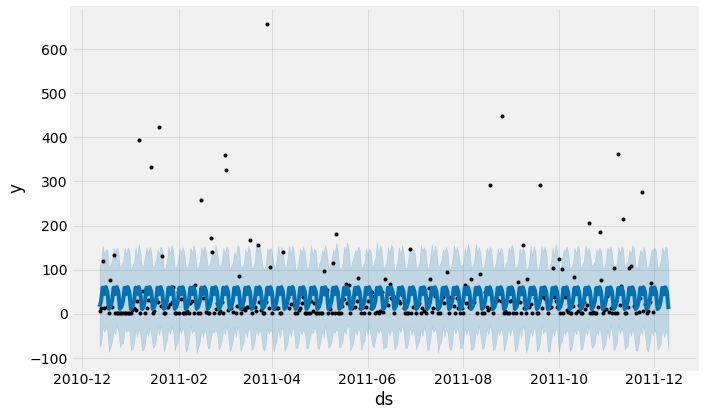

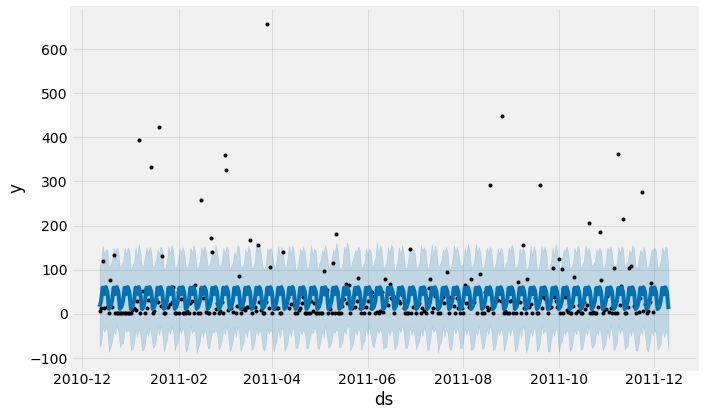

In [176]:
my_model.plot(forecast,uncertainty=True)